#### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 # installed from opencv-python
import os

#### Define functions

In [2]:
def fetch_data(type):
    """Returns a dataframe of either 'train' or 'val' img."""
    df = pd.read_csv(type + '_outdoor.csv')
    df = df.drop(df.columns[[3]], axis=1)
    df.columns = ['image', 'depth', 'mask']
    df = df.sample(frac=1)
    df = df.reset_index()

    return df

def load_img(img_path):
    """Returns a transformed image."""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,192))
    return img

def load_npy(depth_path, mask_path):
    """Returns the depth map of a numpy array and its mask."""
    depth = np.load(depth_path).squeeze()
    mask = np.load(mask_path)
    mask = mask > 0

    min_depth = 0.1
    max_depth = min(300, np.percentile(depth, 99))
    depth = np.clip(depth, min_depth, max_depth)
    depth = np.log(depth, where=mask)

    depth = np.ma.masked_where(~mask, depth)
    depth = cv2.resize(depth, (256,192))

    return depth

def show_samples(sample1, sample2):
    """Displays the images and depth maps of the training and validation set."""
    cmap = plt.cm.jet
    cmap.set_bad(color='black')

    fig, ax = plt.subplots(5, 4, figsize=(40, 40))
    for i in range(5):
        ax[i, 0].imshow(load_img(sample1["image"][i]))
        ax[i, 1].imshow(load_npy(sample1["depth"][i],sample1["mask"][i]), cmap=cmap)
        ax[i, 2].imshow(load_img(sample2["image"][i]))
        ax[i, 3].imshow(load_npy(sample2["depth"][i],sample2["mask"][i]), cmap=cmap)
        for j in range (4):
            ax[i, j].axis('off')

        titles = ['train img', 'train depth', 'val img', 'val depth']
        for i in range(4):
            ax[0, i].set_title(titles[i], fontdict={'fontsize':55})

    plt.tight_layout()
    plt.show()

#### Visualize DIODE samples

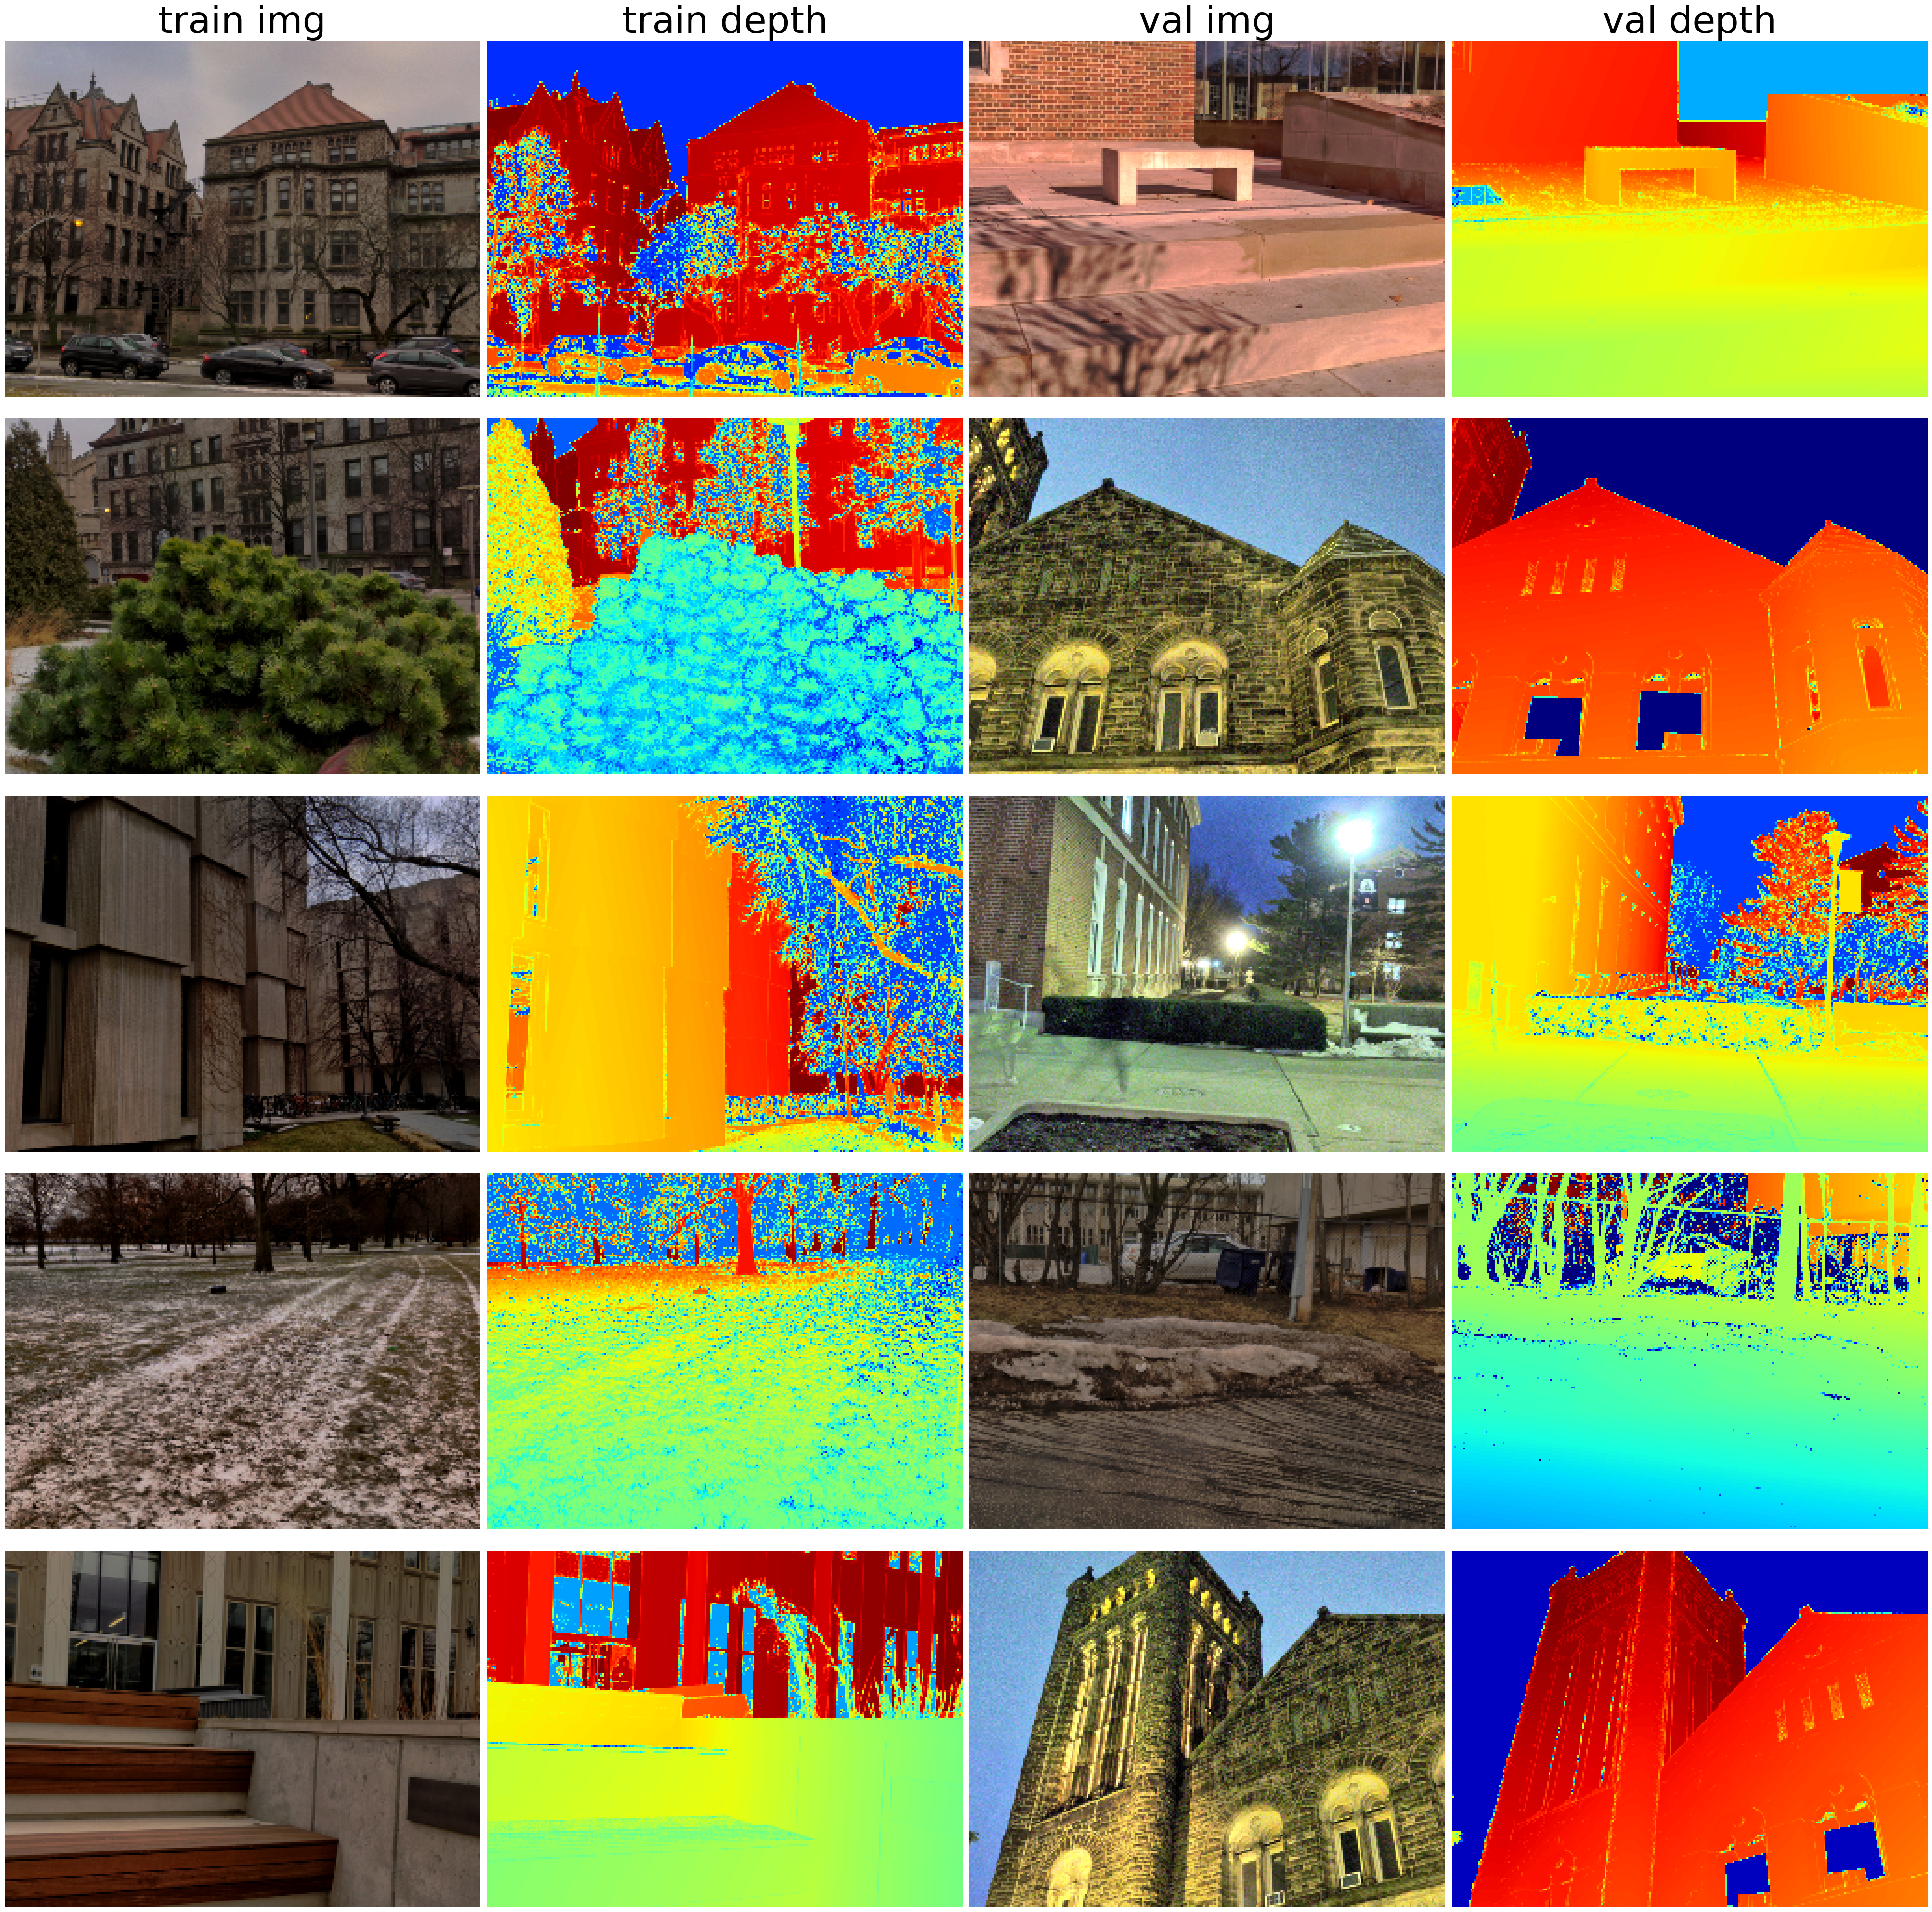

In [4]:
os.chdir('D:\\Informatics\\Μεταπτυχιακό\\Εξάμηνο Γ\\dataset')
train = fetch_data('train')
val = fetch_data('val')

show_samples(train, val)

#### Show BANet results

In [22]:
def visualize_depth_map(samples, test=False, model=None):
    input, target = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    if test:
        pred = model.predict(input)
        fig, ax = plt.subplots(6, 3, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
            ax[i, 2].imshow((pred[i].squeeze()), cmap=cmap)

    else:
        fig, ax = plt.subplots(6, 2, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)

In [38]:
# prepare the dataset
os.chdir('D:\\Informatics\\Μεταπτυχιακό\\Εξάμηνο Γ\\dataset')

val = pd.read_csv('val_outdoor.csv')
val = val.drop(val.columns[[3]], axis=1)
val.columns = ['image', 'depth', 'mask']
val = val.sample(frac=1)

test_loader = next(iter(DataGenerator(data=val[265:].reset_index(drop="true"), batch_size=6, dim=(256, 256))))

os.chdir('C:\\Users\\StarWars\\Documents\\GitHub\\MSc_Thesis\\banet-depth-prediction\\models')
model = BANet_DenseNet121()
model.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))
pred = model.predict(test_loader)

#visualize_depth_map(test_loader, test=True, model=model)

C:\Users\StarWars\Documents\GitHub\MSc_Thesis\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\StarWars\Documents\GitHub\MSc_Thesis\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AttributeError: 'BANet_DenseNet121' object has no attribute 'predict'

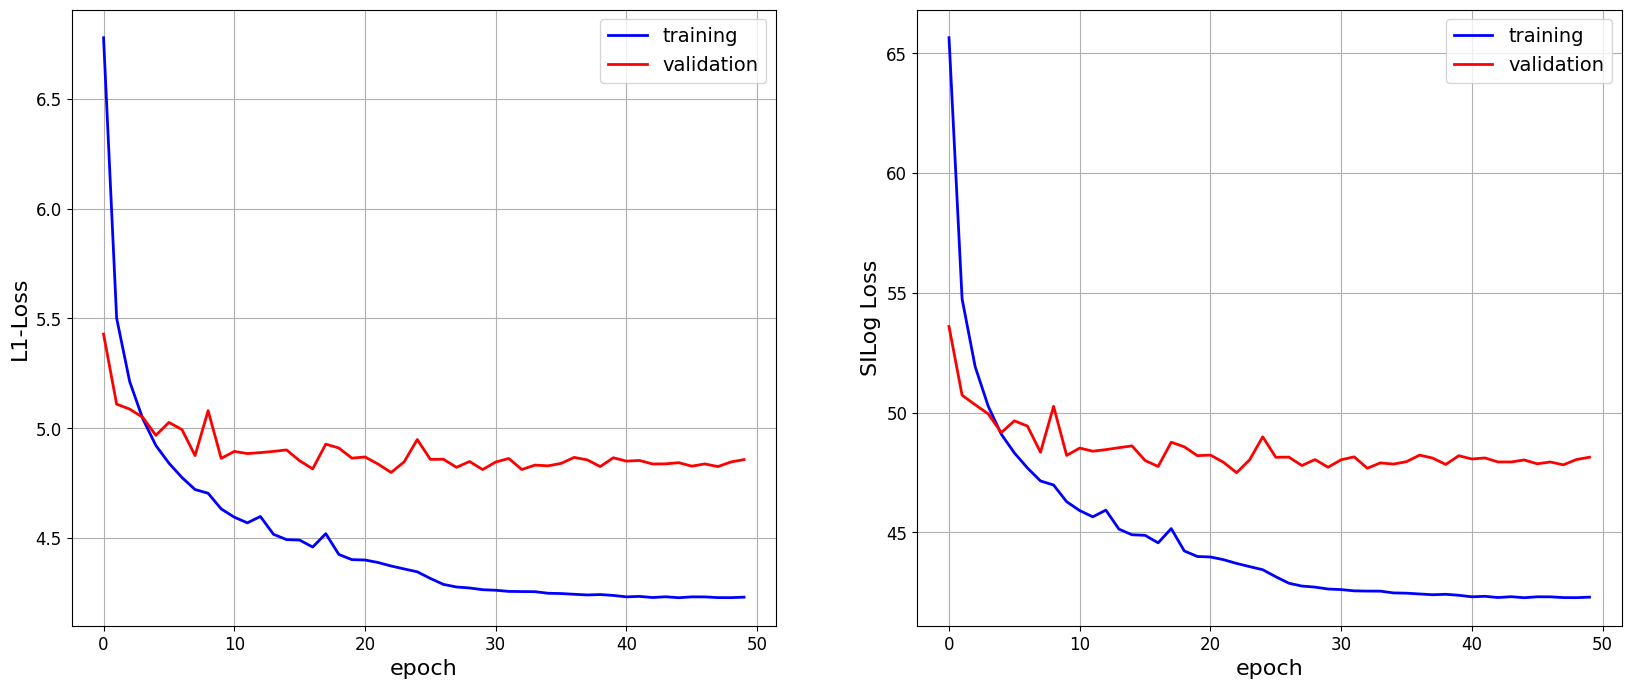

In [29]:
# prepare metrics dataframe
os.chdir('C:\\Users\\StarWars\\Documents\\GitHub\\MSc_Thesis\\banet-depth-prediction')
metrics = pd.read_csv('tmetrics.csv')

# show the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

# Plot validation L1-Loss
ax1.plot(metrics['Train Loss'], 'b', linewidth=2)
ax1.plot(metrics['Test Loss'], 'r', linewidth=2)
ax1.legend(['training', 'validation'], fontsize=14)
ax1.set_xlabel('epoch', fontsize=16)
ax1.set_ylabel('L1-Loss', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.grid()

# Plot validation SILog Loss
ax2.plot(metrics['Train SILog'], 'b', linewidth=2)
ax2.plot(metrics['Test SILog'], 'r', linewidth=2)
ax2.legend(['training', 'validation'], fontsize=14)
ax2.set_xlabel('epoch', fontsize=16)
ax2.set_ylabel('SILog Loss', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.grid()